In [2]:
import pandas as pd
import numpy as np
import math
import cv2
import sys
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from PIL import Image
import imutils
import array
import collections
import time
import copy

In [3]:
def extract_seed_pixels(stroke_im,im):
    arr=np.array(stroke_im)
    arr1=np.array(im)
    blue =np.array([6, 0, 255])
    red =np.array([255, 0, 0])
    m=0
    n=0
    C=[]
    D=[]
    for i in range (0,len(arr)):
        for j in range (0,len(arr[0])):
            if (arr[i][j][0] == blue[0] and arr[i][j][1] == blue[1] and arr[i][j][2] == blue[2] ):                                                    
                C=np.append(C, [[arr1[i][j][0], arr1[i][j][1], arr1[i][j][2]]] )
                m=m+1
            elif (arr[i][j][0] == red[0] and arr[i][j][1] == red[1] and arr[i][j][2] == red[2]):
                D=np.append(D, [[arr1[i][j][0], arr1[i][j][1], arr1[i][j][2]]] )
                n=n+1
    print(C)
    bg=C.reshape(m,3)          
    fg=D.reshape(n,3)         
    print(bg.shape)
    print(fg.shape)
    return fg, bg     


In [4]:
def get_index(arr,cent):
    imd=[]
    for w in range (0,len(arr)):
        dis=[]
        for i in range (len(cent)):
            d=arr[w]-cent[i]
            dd=(np.linalg.norm(d))
            dis=np.append(dis,dd)
        imd=np.append(imd,np.argmin(dis))
    
    return imd

def generate_centroids(k,arr):
    hi=0
    centroid=[]
    while hi < k*3:
        r=np.random.randint(np.amin(np.amin(arr)), np.amax(np.amax(arr)))
        if r not in centroid:
            hi += 1
            centroid=np.append(centroid,r)
    c=centroid.reshape(k,3)
    return c

def update_centroid(arr,ind,k):
    avg=[]
    
    for i in range (k):
        hh=[]
        m=0
        for j in range(len(arr)):
            if ind[j]==i:
                hh=np.append(hh,arr[j])
                m+=1
        if len(hh)!=0:
            hh=hh.reshape(m,3)
            avg=np.append(avg,(sum(hh)/len(hh)))
            
        else:
            avg=np.append(avg,arr[i])
            
    avg=avg.reshape(k,3)
    
    return avg 

In [25]:
def kmeanalgo(k,arr):
    centroids=generate_centroids(k,arr)
    cent_1=np.empty_like(centroids)
    it=0
    while not np.array_equal(cent_1,centroids):
        if it<=200:
            it+=1
            cent_1=centroids
            index=get_index(arr,centroids)
            centroids=update_centroid(arr,index,k)
        else:
            cent_1=centroids
    print('total number of iterations:')
    print(it)
    return centroids,index

In [6]:
def weight(cent,index):
    tsp=len(index)
    k=len(cent)
    num=[]
    for i in range (k):
        l=0
        for j in range (tsp):
            if index[j]==i:
                l+=1
        num=np.append(num,l)
    weigh=num/tsp
    return weigh
            

In [7]:
def calc_prob(image,fore_cent, fore_dp_in_cent, back_cent, back_dp_in_cent):

       
    imag1 = image
    im1=np.array(imag1)
    print(im1.shape)

    fww=weight(fore_cent, fore_dp_in_cent)
    bww=weight(back_cent, back_dp_in_cent)

    b_w=np.zeros([len(im1), len(im1[0]),3])
    imgg=b_w
    p1=np.zeros([1,3])
    #add=0
    
    for i in range(0, len(im1)):
        for j in range(0, len(im1[0])): 
            p1[0][0]=im1[i][j][0]
            p1[0][1]=im1[i][j][1]
            p1[0][2]=im1[i][j][2]
            
            
            add=0
            for k in range(0, len(fore_cent)):
                wk= fww[k]
                norm1=(np.linalg.norm(p1-fore_cent[k]))
                expo=math.exp(-(norm1))
                add=add+ (wk* expo)
            fore_ground=add     
            
            add_1=0
            for m in range(0, len(back_cent)):
                wk_1= bww[m]
                norm_1=(np.linalg.norm(p1-back_cent[m]))
                expo_1=math.exp(-norm_1)
                add_1=add_1+ (wk_1* expo_1)
            back_ground=add_1 
            
            if fore_ground > back_ground: 
                b_w[i][j]=[255,255,255]
                
            else: 
                b_w[i][j]=[0,0,0]  
    return b_w

In [8]:
def mydisplay(bw,image):
    im=np.array(image.copy())
    im1=np.array(image.copy())
    for i in range (len(bw)):
        for j in range (len(bw[0])):
            if bw[i][j][0]==0:
                im[i][j]=[0,0,0]
    for i in range (len(bw)):
        for j in range (len(bw[0])):
            if bw[i][j][0]!=0:
                im1[i][j]=[0,0,0]
    dst = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    dst1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
    dst2=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(dst)
    plt.show()
    plt.imshow(dst1)
    plt.show()
    cv2.imshow('image',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('image',im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    cv2.imshow('image',im1)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return dst2,dst,dst1


In [9]:
def lazySnapping(image,si,k):
    s_image=si
    st=time.time()
    f,b=extract_seed_pixels(s_image,image)
    cf,i_f=kmeanalgo(k,f)
    cb,ib=kmeanalgo(k,b)
    bw=calc_prob(image,cf,i_f, cb, ib)
    img,fog,bag=mydisplay(bw,image)
    ed=time.time()
    print("process time in minutes")
    print((ed-st)/60)
    return fog,bag
    

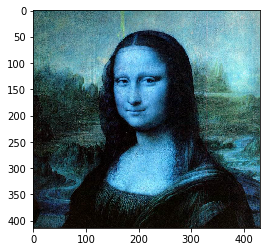

In [10]:
ladys1 =Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\lady stroke 1.png')
ladys2=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\lady stroke 2.png')
lady=cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\lady.PNG')

dog=cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\dog.PNG')
dogs=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\dog stroke.PNG')

dance=cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\dance.PNG')
dances1=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\dance stroke 1.PNG')
dances2=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\dance stroke 2.PNG')

ML=cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\Mona-lisa.PNG')
MLs1=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\Mona-lisa stroke 1.PNG')
MLs2=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\Mona-lisa stroke 2.PNG')

vanG=cv2.imread(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\van Gogh.PNG')
vanGs=Image.open(r'C:\Users\AZKA REHMAN\Desktop\8th sem\CV\Assign2_handout\test_images\van Gogh stroke.PNG')


[119. 123.  98. ... 132. 160. 115.]
(2159, 3)
(3012, 3)
total number of iterations:
76
total number of iterations:
76
(384, 512, 3)


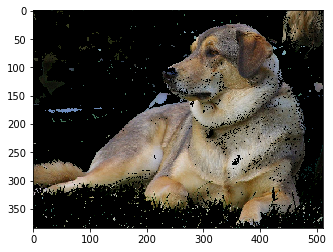

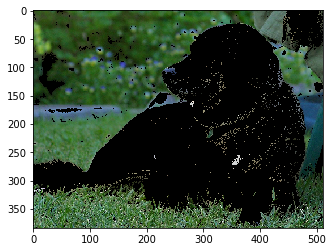

process time in minutes
20.939839613437652


In [33]:
#dog
#lazySnapping(dog,dogs,64)
lazySnapping(lady,ladys1,31)
lazySnapping(lady,ladys2,31)
#lazySnapping(vanG,vanGs,64)
